In [1]:
!pip install -U torch torchvision


Requirement already up-to-date: torch in /usr/local/lib/python3.7/dist-packages (1.8.1+cu101)
Requirement already up-to-date: torchvision in /usr/local/lib/python3.7/dist-packages (0.9.1+cu101)


In [2]:
# установка подходящей версии torch

from os.path import exists
#from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
#platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

#!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

In [3]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
# 
# if it prints otherwise, then you need to enable GPU: 
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np
print(torch.version.cuda)
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

10.1
CUDA is available!  Training on GPU ...


In [4]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [5]:
!unzip -q /content/gdrive/My\ Drive/my_dataset.zip -d task

In [5]:
!unzip -q /content/gdrive/My\ Drive/small_dataset.zip -d task

In [6]:
!ls train

ls: cannot access 'train': No such file or directory


In [6]:
!nvidia-smi
import torch
torch.cuda.is_available()

Sun Apr 11 13:26:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    10W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

In [7]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [8]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

 +3 аугментации на тренировочную выборку



In [9]:
class CoinsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        transform_train =  transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])

        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        if self.mode == 'test':
            x = transform_test(x)
            return x
        else:
            if self.mode == 'val':
                x = transform_test(x)
            else:
                x = transform_train(x)
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

+grayscale на тренировочную выборку


In [21]:
class CoinsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform_test = transforms.Compose([
            transforms.ToTensor(),
            #transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)),
            transforms.Grayscale(3),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        transform_train =  transforms.Compose([
            transforms.ToTensor(),
            transforms.Grayscale(3),
            #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0, hue=0),
            transforms.GaussianBlur(kernel_size=9, sigma=(0.1, 2.0)),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])

        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        if self.mode == 'test':
            x = transform_test(x)
            return x
        else:
            if self.mode == 'val':
                x = transform_test(x)
            else:
                x = transform_train(x)
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [10]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [11]:
TRAIN_DIR = Path('task/small_dataset/train')
TEST_DIR = Path('task/small_dataset/test')

#train_val_files = list(TRAIN_DIR.rglob('*.jpg')) 
#print(train_val_files)
train_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
val_files = sorted(list(TEST_DIR.rglob('*.jpg')))
print(val_files)

[PosixPath('task/small_dataset/test/100с/1.jpg'), PosixPath('task/small_dataset/test/100с/10.jpg'), PosixPath('task/small_dataset/test/100с/100.jpg'), PosixPath('task/small_dataset/test/100с/101.jpg'), PosixPath('task/small_dataset/test/100с/102.jpg'), PosixPath('task/small_dataset/test/100с/103.jpg'), PosixPath('task/small_dataset/test/100с/104.jpg'), PosixPath('task/small_dataset/test/100с/105.jpg'), PosixPath('task/small_dataset/test/100с/106.jpg'), PosixPath('task/small_dataset/test/100с/107.jpg'), PosixPath('task/small_dataset/test/100с/108.jpg'), PosixPath('task/small_dataset/test/100с/11.jpg'), PosixPath('task/small_dataset/test/100с/12.jpg'), PosixPath('task/small_dataset/test/100с/13.jpg'), PosixPath('task/small_dataset/test/100с/14.jpg'), PosixPath('task/small_dataset/test/100с/15.jpg'), PosixPath('task/small_dataset/test/100с/16.jpg'), PosixPath('task/small_dataset/test/100с/17.jpg'), PosixPath('task/small_dataset/test/100с/18.jpg'), PosixPath('task/small_dataset/test/100с/1

In [12]:
val_dataset = CoinsDataset(val_files, mode='val')

223
298
104
291
151
229
269
169
58


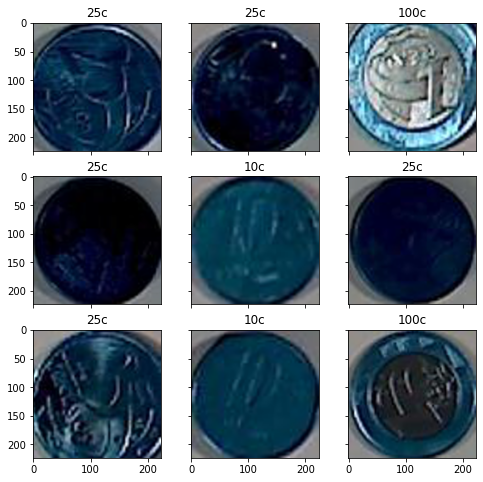

In [13]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), 
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,300))
    print(random_characters)
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), 
          title=img_label,plt_ax=fig_x)

In [14]:
import torchvision.models as models

In [15]:
model_1 = models.resnet50(pretrained=True)

# замораживаем параметры (веса)
for param in model_1.parameters():
    param.requires_grad = False
for param in model_1.layer4.parameters():
    param.requires_grad = True  

model_1.fc = nn.Sequential(
    nn.Linear(2048, 1024),
    nn.ReLU(),
    nn.BatchNorm1d(1024),
    nn.Linear(1024, 128),
    nn.ReLU(),
    nn.Linear(128, 15)
)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [16]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler=None):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data

    if scheduler is not None:
        scheduler.step()
    return train_loss, train_acc

In [17]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc
    

In [18]:
from torch.optim.lr_scheduler import ExponentialLR
from torch.optim import AdamW

In [19]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = AdamW(model.parameters(), lr=0.0005)
        scheduler = ExponentialLR(optimizer=opt, gamma=0.85)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt, scheduler)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [20]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [21]:
#n_classes = len(np.unique(train_labels))
my_cnn_1 = model_1.to(DEVICE)
print("we will classify :{}".format(15))
print(my_cnn_1)

we will classify :15
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_siz

In [22]:
if val_dataset is None:
    val_dataset = CoinsDataset(val_files, mode='val')
    
train_dataset = CoinsDataset(train_files, mode='train')

In [23]:
history = train(train_dataset, val_dataset, model=my_cnn_1, epochs=10, batch_size=32)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 0.525872124434236


epoch:  10%|█         | 1/10 [00:13<02:03, 13.70s/it]


Epoch 001 train_loss: 0.5259     val_loss 0.4039 train_acc 0.8746 val_acc 0.8987
loss 0.2875148923399579


epoch:  20%|██        | 2/10 [00:26<01:48, 13.55s/it]


Epoch 002 train_loss: 0.2875     val_loss 1.1880 train_acc 0.9241 val_acc 0.7495
loss 0.14650843563815774


epoch:  30%|███       | 3/10 [00:40<01:34, 13.48s/it]


Epoch 003 train_loss: 0.1465     val_loss 1.9369 train_acc 0.9578 val_acc 0.7569
loss 0.10579759681585002


epoch:  40%|████      | 4/10 [00:53<01:20, 13.45s/it]


Epoch 004 train_loss: 0.1058     val_loss 0.2719 train_acc 0.9705 val_acc 0.9374
loss 0.05279406350647167


epoch:  50%|█████     | 5/10 [01:07<01:07, 13.46s/it]


Epoch 005 train_loss: 0.0528     val_loss 0.1530 train_acc 0.9831 val_acc 0.9521
loss 0.036346540322068084


epoch:  60%|██████    | 6/10 [01:20<00:54, 13.51s/it]


Epoch 006 train_loss: 0.0363     val_loss 0.2138 train_acc 0.9885 val_acc 0.9576
loss 0.03237903520219015


epoch:  70%|███████   | 7/10 [01:34<00:40, 13.58s/it]


Epoch 007 train_loss: 0.0324     val_loss 0.1747 train_acc 0.9898 val_acc 0.9448
loss 0.023757901763506437


epoch:  80%|████████  | 8/10 [01:48<00:27, 13.69s/it]


Epoch 008 train_loss: 0.0238     val_loss 0.2995 train_acc 0.9922 val_acc 0.9392
loss 0.014136942011158803


epoch:  90%|█████████ | 9/10 [02:02<00:13, 13.73s/it]


Epoch 009 train_loss: 0.0141     val_loss 0.2749 train_acc 0.9946 val_acc 0.9355
loss 0.004607777218034041


epoch: 100%|██████████| 10/10 [02:15<00:00, 13.59s/it]


Epoch 010 train_loss: 0.0046     val_loss 0.2122 train_acc 0.9988 val_acc 0.9429


In [104]:
Path = ("brazilian_model.pt")
torch.save(my_cnn_1, Path)

In [105]:
model = torch.load(Path)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
#training 4 and fc layers with augmentations
plt.figure(figsize=(15, 9))
loss, acc, val_loss, val_acc = zip(*history)
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(acc, label="train_accuracy")
plt.plot(val_acc, label="val_accuracy")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

In [26]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [27]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

Detection

In [81]:
import numpy as np
import cv2

In [82]:
image = cv2.imread("95_1477857912.jpg")

In [43]:
d = 1024 / image.shape[1]
dim = (1024, int(image.shape[0] * d))
image = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)

In [101]:
output = image.copy()

In [84]:
gray_im = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray_im, (3, 3), 1)

In [35]:
clf = model

In [85]:
diameter = []
materials = []
coordinates = []

In [37]:
from google.colab.patches import cv2_imshow
from PIL import Image

In [86]:
circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, 1.2, 20, param2=70)

In [39]:
from pathlib import Path

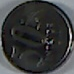

1


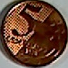

2


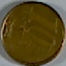

3


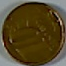

4


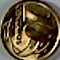

5


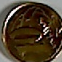

6


In [87]:
count = 0
if circles is not None:
    # append radius to list of diameters (we don't bother to multiply by 2)
    for (x, y, r) in circles[0, :]:
        diameter.append(r)

    # convert coordinates and radii to integers
    circles = np.round(circles[0, :]).astype("int")

    # loop over coordinates and radii of the circles
    for (x, y, d) in circles:
        count += 1

        # add coordinates to list
        coordinates.append((x, y))

        # extract region of interest
        roi = image[y - d:y + d, x - d:x + d]
        path = 'coins/' + str(count) + '.jpg'
        roi_im = Image.fromarray(roi)   
        roi_im.save(path) 
        
        VAL_DIR = Path('coins')
        val_files = sorted(list(VAL_DIR.rglob('*.jpg')))
        val_dataset = CoinsDataset(val_files, "val")
        
        cv2_imshow(roi)
        if count == 10:
            break
        print(count)

In [88]:
labels = []
classes_dict = {'5c': 5, '10c': 10, '25c': 25, '50c': 50, '100c': 100}

In [47]:
print(coordinates)

[(245, 147), (549, 63), (349, 163), (165, 71), (95, 215), (452, 64)]


In [89]:
VAL_DIR = Path('coins')
val_files = sorted(list(VAL_DIR.rglob('*.jpg')))
print(val_files)
val_dataset = CoinsDataset(val_files, "val")

for i in range(count):

    im, label = val_dataset[i]
    prob_pred = predict_one_sample(clf, im.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    labels.append(predicted_label)
    print(predicted_label)

[PosixPath('coins/1.jpg'), PosixPath('coins/2.jpg'), PosixPath('coins/3.jpg'), PosixPath('coins/4.jpg'), PosixPath('coins/5.jpg'), PosixPath('coins/6.jpg')]
50c
5c
10c
10c
10c
10c


In [90]:
print(labels)

['50c', '5c', '10c', '10c', '10c', '10c']


In [91]:
def count_sum(labels, classes_dict):
    total = 0
    for item in labels:
        total += classes_dict[item]
    return total

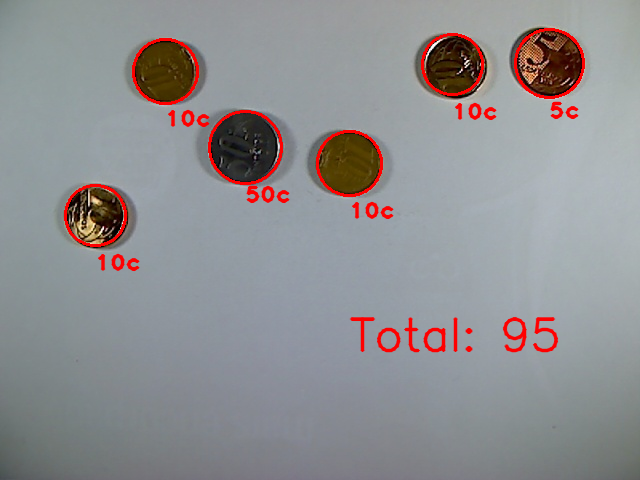

In [102]:
for i in range(len(labels)):
    d = diameter[i]
    (x, y) = coordinates[i]
    cv2.circle(output, (x, y), d, (0, 0, 255), 2)
    cv2.putText(output, labels[i],
                    (x, y + 55), cv2.FONT_HERSHEY_PLAIN,
                    1.5, (0, 0, 255), thickness=2, lineType=cv2.LINE_AA)
total = count_sum(labels, classes_dict)
answer = 'Total: ' + str(total)
cv2.putText(output, answer, (350, 350), cv2.FONT_HERSHEY_SIMPLEX,
            1.5, (0, 0, 255), thickness=2, lineType=cv2.LINE_AA)
cv2_imshow(output)